<div style="text-align: center; padding: 20px; background-color: #000000; border-radius: 10px; margin: 20px 0;">
    <h1 style="color: #008080 	;">Analyze the Likelihood of Scoring a Goal through a Shot<h1>
    <hr style="border: 2px solid #008080;">
</div>

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

In [181]:
DATA_PATH = "./Documents/football.csv"

In [182]:
# Load the data
raw_data = pd.read_csv(DATA_PATH)

In [183]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


In [184]:
raw_data.describe()

,x,y,interveningOpponents,interveningTeammates,minute,second
count,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000,8925.000000
mean,14.564631,0.364408,2.531989,0.336471,48.541401,29.243810
std,7.841865,8.999063,1.386693,0.680175,26.397998,17.306565
min,0.000000,-33.920000,0.000000,0.000000,0.000000,0.000000
25%,8.480000,-5.740000,2.000000,0.000000,26.000000,14.000000
50%,12.470000,0.500000,2.000000,0.000000,49.000000,29.000000
75%,20.950000,6.730000,3.000000,0.000000,71.000000,44.000000
max,70.820000,33.920000,11.000000,7.000000,98.000000,59.000000


In [185]:
raw_data.head()

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [186]:
# show unique values for each column if unique values are less than 10
for column in raw_data.columns:
		if len(raw_data[column].unique()) < 10:
				# color column names blue
				print(f"\033[94m{column}\033[0m")
				print(raw_data[column].unique())
				print()

playType
['open play' 'free kick' 'penalty' 'olimpico']

bodyPart
['right foot' 'left foot' 'head' 'other']

interveningTeammates
[0 2 1 3 4 5 7]

interferenceOnShooter
['medium' 'low' 'high' nan]

outcome
['goal' 'saved by keeper' 'missed chance' 'blocked shot' 'hit the post'
 nan]



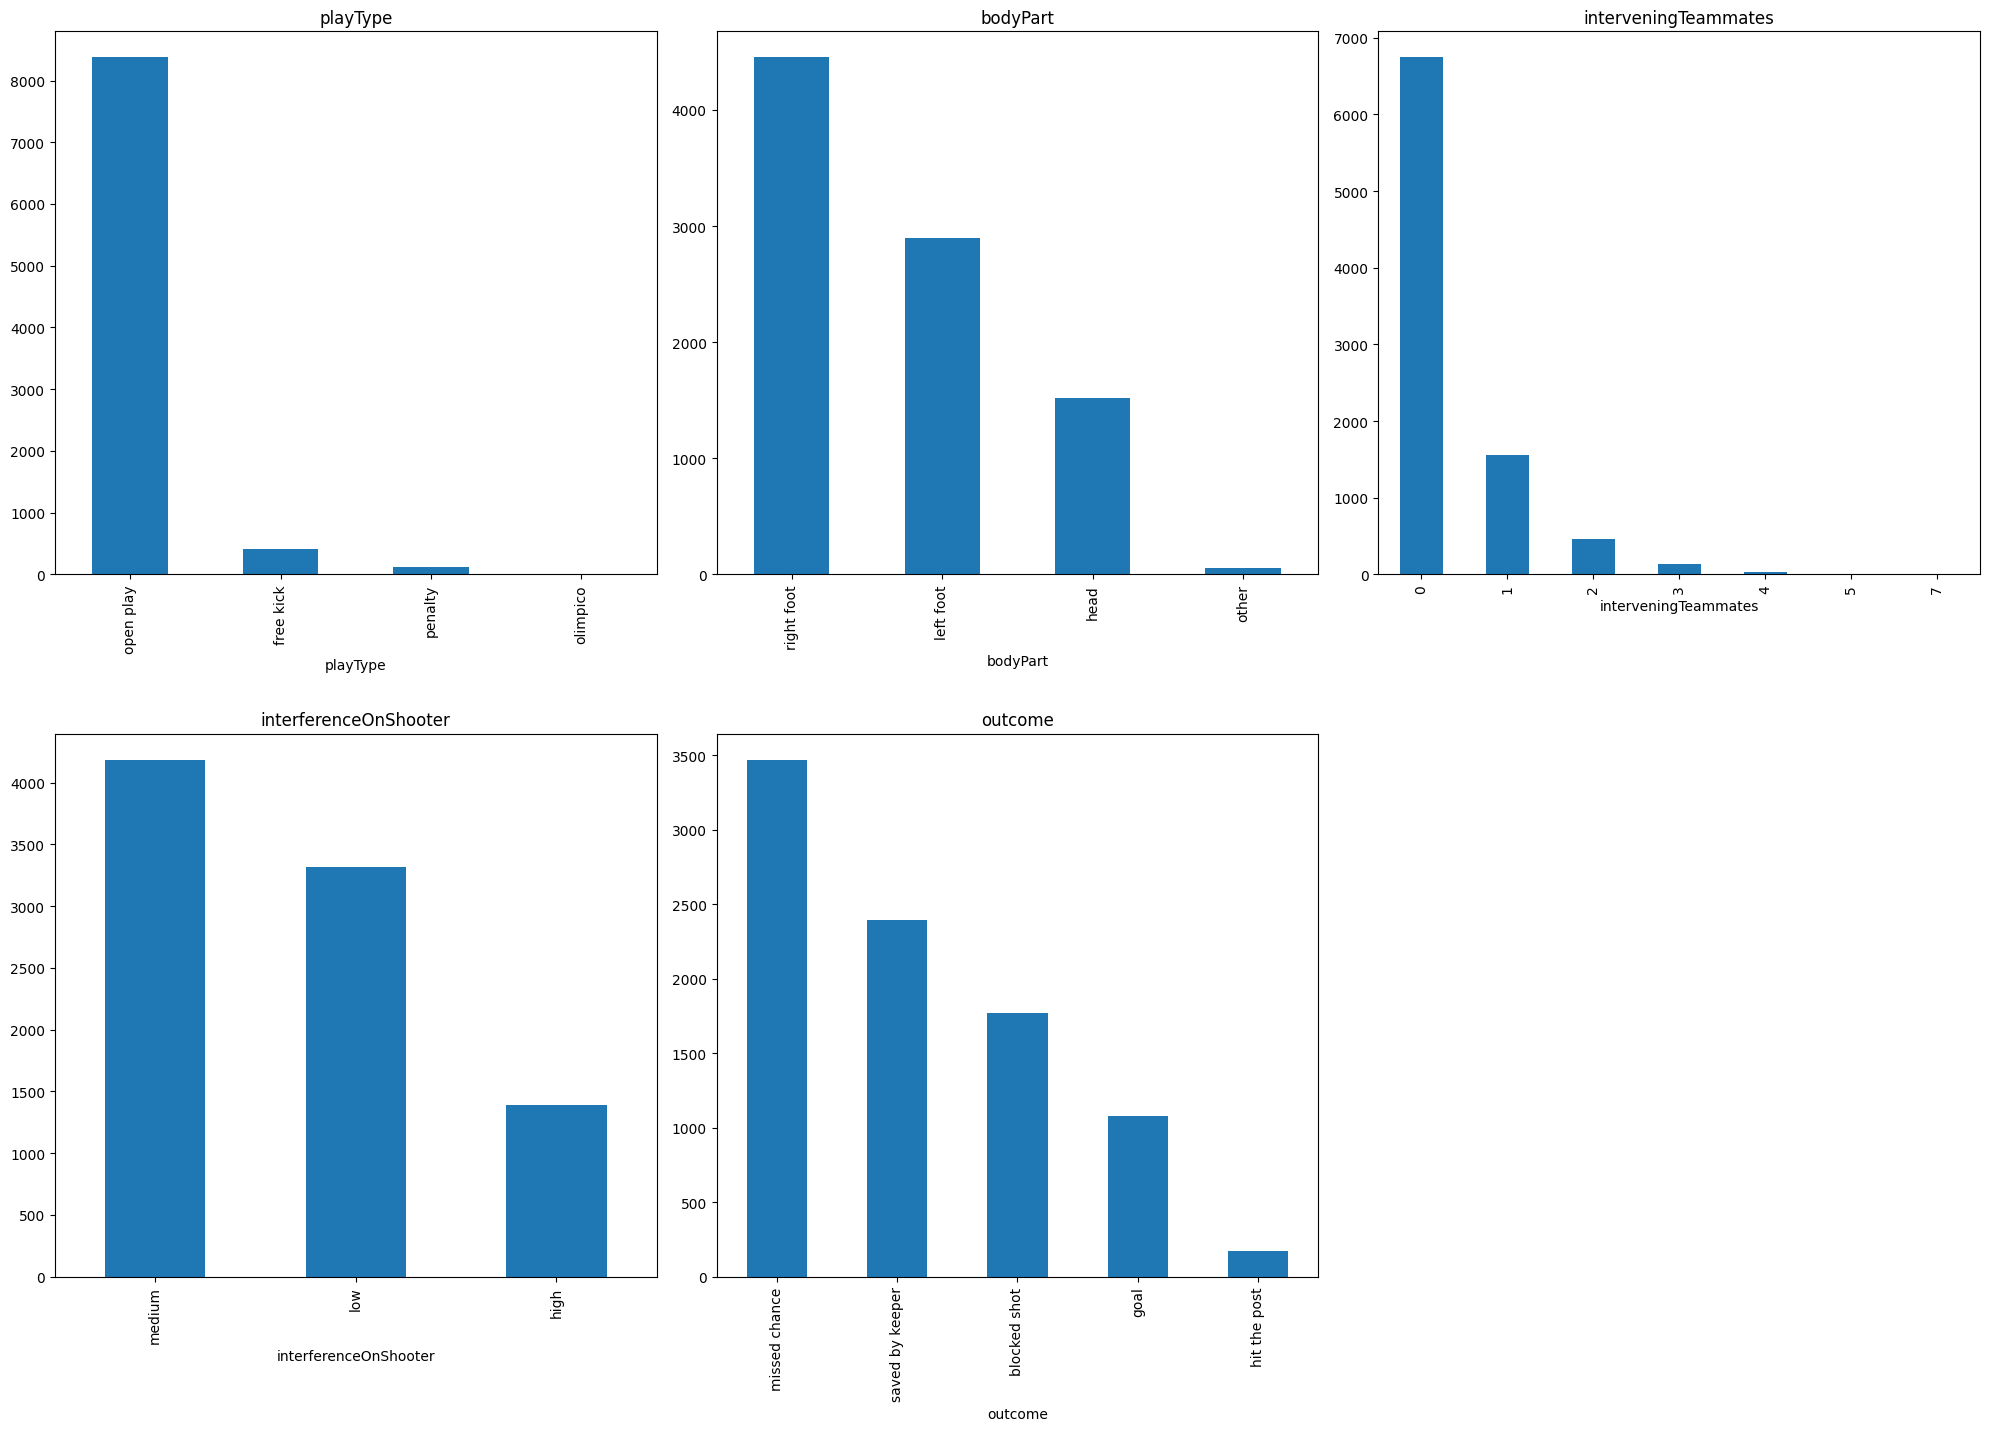

In [187]:
plt.figure(figsize=(20, 20))
j = 0
for column in raw_data.columns:
		if len(raw_data[column].unique()) < 10:
				j += 1
				plt.subplot(3, 3, j)
				raw_data[column].value_counts().plot(kind='bar')
				plt.title(column)

plt.tight_layout()
plt.show()



## Preprocessing the data

In [188]:
# count null or missing values for each column
raw_data.isnull().sum()


matchId                   0
playerId                  0
playType                  0
bodyPart                  0
x                         0
y                         0
interveningOpponents      0
interveningTeammates      0
interferenceOnShooter    34
minute                    0
second                    0
outcome                  34
dtype: int64

In [189]:
# print duplicates
print(raw_data.duplicated().sum())

0


In [190]:
# remove null values rows
clean_data = raw_data.dropna()
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8891 non-null   object 
 1   playerId               8891 non-null   object 
 2   playType               8891 non-null   object 
 3   bodyPart               8891 non-null   object 
 4   x                      8891 non-null   float64
 5   y                      8891 non-null   float64
 6   interveningOpponents   8891 non-null   int64  
 7   interveningTeammates   8891 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8891 non-null   int64  
 10  second                 8891 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 903.0+ KB


In [191]:
# drop matchId & playerId columns
clean_data = clean_data.drop(columns=['matchId', 'playerId'])
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8891 entries, 0 to 8924
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   playType               8891 non-null   object 
 1   bodyPart               8891 non-null   object 
 2   x                      8891 non-null   float64
 3   y                      8891 non-null   float64
 4   interveningOpponents   8891 non-null   int64  
 5   interveningTeammates   8891 non-null   int64  
 6   interferenceOnShooter  8891 non-null   object 
 7   minute                 8891 non-null   int64  
 8   second                 8891 non-null   int64  
 9   outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(4)
memory usage: 764.1+ KB


In [192]:
# convert categorical columns to numerical
le = LabelEncoder()
clean_data['playType'] = le.fit_transform(clean_data['playType'])
clean_data['bodyPart'] = le.fit_transform(clean_data['bodyPart'])
clean_data['interferenceOnShooter'] = le.fit_transform(clean_data['interferenceOnShooter'])
# clean_data['outcome'] = le.fit_transform(clean_data['outcome'])
# if outcome was goal, then 1, else 0
clean_data['outcome'] = clean_data['outcome'].apply(lambda x: 1 if x == 'goal' else 0)
clean_data

,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,2,3,13.47,-11.22,1,0,2,70,9,1
1,2,1,9.48,14.22,3,0,2,55,4,0
2,0,1,29.43,-1.25,6,2,1,86,31,0
3,2,3,26.93,1.00,4,1,2,77,2,0
4,2,3,10.72,5.24,2,0,2,76,46,1
...,...,...,...,...,...,...,...,...,...,...
8920,2,0,6.48,3.99,3,0,0,69,50,0
8921,2,3,21.45,-8.73,4,1,2,15,53,0
8922,2,1,11.97,3.24,3,0,2,84,34,0
8923,2,3,6.48,-6.98,1,0,0,4,39,0


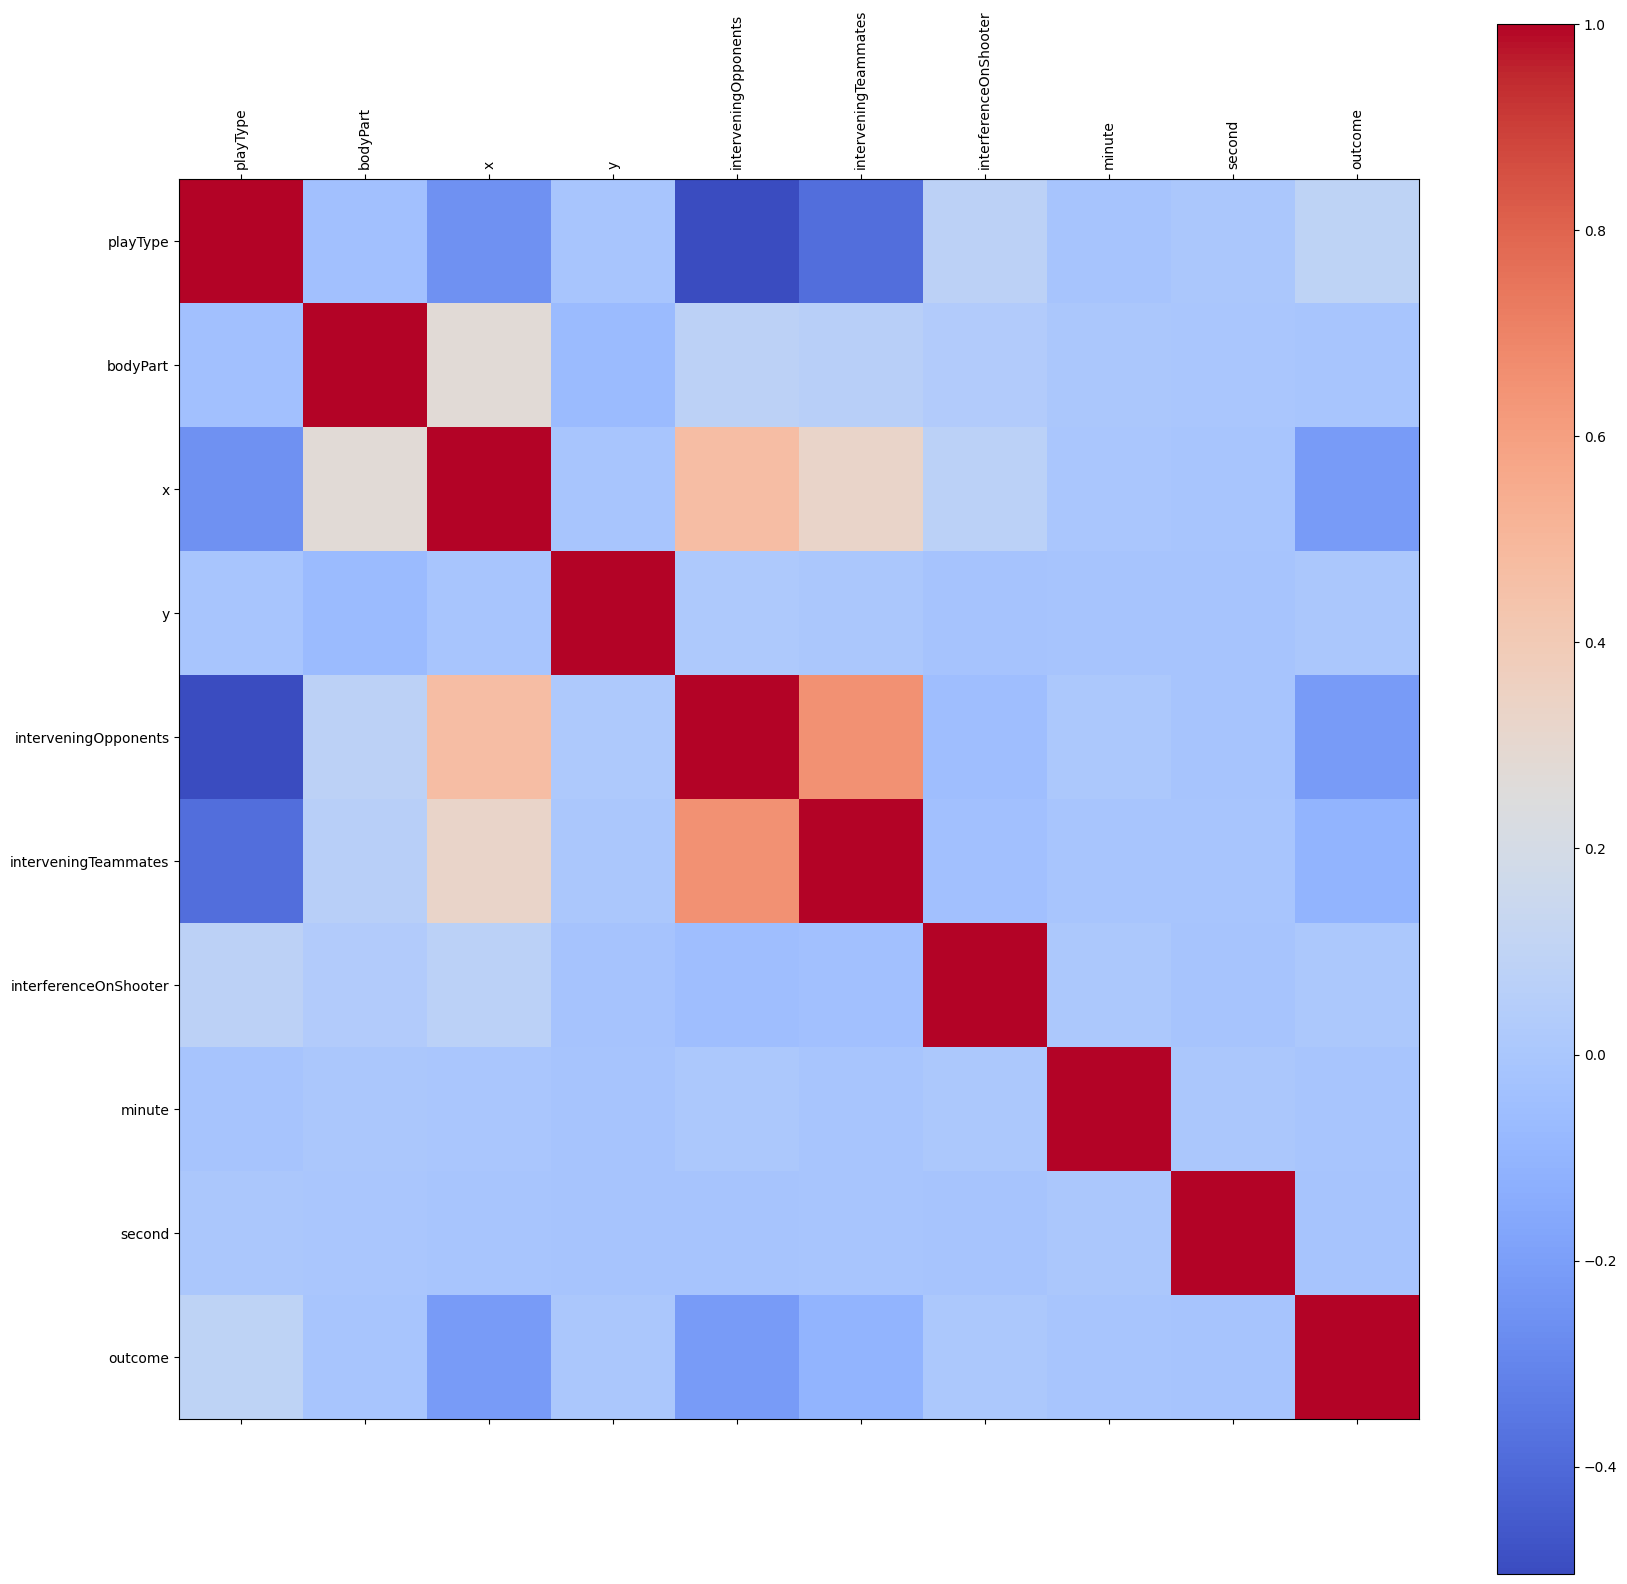

In [193]:
# show correlation matrix in heatmap in coolwarm mode
plt.figure(figsize=(20, 20))
plt.matshow(clean_data.corr(), cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(clean_data.columns)), clean_data.columns, rotation='vertical')
plt.yticks(range(len(clean_data.columns)), clean_data.columns)
plt.show()

In [194]:
# correlation matrix between outcome_goal and other columns
correlation = clean_data.corr()
correlation['outcome'].sort_values(ascending=False)

outcome                  1.000000
playType                 0.089883
interferenceOnShooter    0.008075
y                        0.001947
minute                  -0.006726
bodyPart                -0.008928
second                  -0.012555
interveningTeammates    -0.101162
interveningOpponents    -0.213680
x                       -0.216209
Name: outcome, dtype: float64

In [195]:
X = clean_data.drop(columns=['outcome'])
y = clean_data['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(7112, 9) (7112,)
(1779, 9) (1779,)


In [196]:
# train a model
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier()

In [197]:
# predict
y_pred = model.predict(X_test)

In [198]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")

# confusion matrix
print("Confusion Matrix")
# hint
# [[true_positive, false_negative],
# [false_positive, true_negative]]
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix, "\n")

# classification report
print("Classification Report")
class_report = classification_report(y_test, y_pred)
print(class_report)

Accuracy: 0.8915120854412592

Confusion Matrix
[[1544   20]
 [ 173   42]] 

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      1564
           1       0.68      0.20      0.30       215

    accuracy                           0.89      1779
   macro avg       0.79      0.59      0.62      1779
weighted avg       0.87      0.89      0.86      1779



## Analyzing the results With Feature Engineering

In [199]:
# add distance to the attributes (using radical x^2 + y^2)
clean_data['distance'] = np.sqrt(clean_data['x']**2 + clean_data['y']**2)

# add angle to the attributes (using rad2deg(atan(theta))) where theta = 7.32x / (x^2 + y^2 - (7.32/2)^2)
clean_data['shot_angle'] = np.rad2deg(np.arctan(7.32 * clean_data['x'] / (clean_data['x']**2 + clean_data['y']**2 - (7.32/2)**2)))

clean_data

,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,distance,shot_angle
0,2,3,13.47,-11.22,1,0,2,70,9,1,17.530810,18.544088
1,2,1,9.48,14.22,3,0,2,55,4,0,17.090313,13.982592
2,0,1,29.43,-1.25,6,2,1,86,31,0,29.456534,14.153255
3,2,3,26.93,1.00,4,1,2,77,2,0,26.948560,15.458384
4,2,3,10.72,5.24,2,0,2,76,46,1,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...,...,...
8920,2,0,6.48,3.99,3,0,0,69,50,0,7.609895,46.818116
8921,2,3,21.45,-8.73,4,1,2,15,53,0,23.158484,16.713121
8922,2,1,11.97,3.24,3,0,2,84,34,0,12.400746,31.970470
8923,2,3,6.48,-6.98,1,0,0,4,39,0,9.524222,31.529506


In [200]:
clean_data = clean_data.drop(columns=['x','y'])

clean_data_without_time = clean_data.drop(columns=['minute','second'])
clean_data

,playType,bodyPart,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome,distance,shot_angle
0,2,3,1,0,2,70,9,1,17.530810,18.544088
1,2,1,3,0,2,55,4,0,17.090313,13.982592
2,0,1,6,2,1,86,31,0,29.456534,14.153255
3,2,3,4,1,2,77,2,0,26.948560,15.458384
4,2,3,2,0,2,76,46,1,11.932141,31.315918
...,...,...,...,...,...,...,...,...,...,...
8920,2,0,3,0,0,69,50,0,7.609895,46.818116
8921,2,3,4,1,2,15,53,0,23.158484,16.713121
8922,2,1,3,0,2,84,34,0,12.400746,31.970470
8923,2,3,1,0,0,4,39,0,9.524222,31.529506


In [201]:
# train clean_data with time
X_time = clean_data.drop(columns=['outcome'])
y_time = clean_data['outcome']

X_train_time, X_test_time, y_train_time, y_test_time = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

model_time = RandomForestClassifier()
model_time.fit(X_train_time, y_train_time)

y_pred_time = model_time.predict(X_test_time)

accuracy_time = accuracy_score(y_test_time, y_pred_time)
print(f"Accuracy: {accuracy_time}\n")

conf_matrix_time = confusion_matrix(y_test_time, y_pred_time)
print(conf_matrix_time, "\n")

class_report_time = classification_report(y_test_time, y_pred_time)
print(class_report_time)

Accuracy: 0.8915120854412592

[[1536   28]
 [ 165   50]] 

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      1564
           1       0.64      0.23      0.34       215

    accuracy                           0.89      1779
   macro avg       0.77      0.61      0.64      1779
weighted avg       0.87      0.89      0.87      1779



In [202]:
# train clean_data without time
X_without_time = clean_data_without_time.drop(columns=['outcome'])
y_without_time = clean_data_without_time['outcome']

X_train_without_time, X_test_without_time, y_train_without_time, y_test_without_time = train_test_split(X_without_time, y_without_time, test_size=0.2, random_state=42)

model_without_time = RandomForestClassifier()
model_without_time.fit(X_train_without_time, y_train_without_time)

y_pred_without_time = model_without_time.predict(X_test_without_time)

accuracy_without_time = accuracy_score(y_test_without_time, y_pred_without_time)
print(f"Accuracy: {accuracy_without_time}\n")

conf_matrix_without_time = confusion_matrix(y_test_without_time, y_pred_without_time)
print(conf_matrix_without_time, "\n")

class_report_without_time = classification_report(y_test_without_time, y_pred_without_time)
print(class_report_without_time)


Accuracy: 0.8791455874086566

[[1504   60]
 [ 155   60]] 

              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1564
           1       0.50      0.28      0.36       215

    accuracy                           0.88      1779
   macro avg       0.70      0.62      0.65      1779
weighted avg       0.86      0.88      0.86      1779



In [203]:
# correlation matrix between outcome_goal and other columns
correlation = clean_data.corr()
correlation['outcome'].sort_values(ascending=False)

outcome                  1.000000
shot_angle               0.128599
playType                 0.089883
interferenceOnShooter    0.008075
minute                  -0.006726
bodyPart                -0.008928
second                  -0.012555
interveningTeammates    -0.101162
interveningOpponents    -0.213680
distance                -0.260733
Name: outcome, dtype: float64